# Object Detection with KerasCV

Train Yolo object detection model with KerasCV.

In [6]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [7]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import os

#os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

In [2]:
import tensorflow as tf
if tf.__version__ < "2.15":
    !pip install --upgrade tensorflow

## Object detection introduction

Object detection is the process of identifying, classifying,
and localizing objects within a given image.  Typically, your inputs are
images, and your labels are bounding boxes with optional class
labels.
Object detection can be thought of as an extension of classification, however
instead of one class label for the image, you must detect and localize an
arbitrary number of classes.


## Perform detections with a pretrained model


The highest level API in the KerasCV Object Detection API is the `keras_cv.models` API.

This API includes fully pretrained object detection models, such as
`keras_cv.models.YOLOV8Detector`.

Let's get started by constructing a YOLOV8Detector pretrained on the `pascalvoc`
dataset.

In [3]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

100%|██████████| 2.27k/2.27k [00:00<00:00, 3.50MB/s]
100%|██████████| 99.5M/99.5M [00:01<00:00, 59.5MB/s]


Notice the `bounding_box_format`

Recall in the section above, the format of bounding boxes:

```
bounding_boxes = {
  "classes": [num_boxes],
  "boxes": [num_boxes, 4]
}
```

This argument describes *exactly* what format the values in the `"boxes"`
field of the label dictionary take in your pipeline.
For example, a box in `xywh` format with its top left corner at the coordinates
(100, 100) with a width of 55 and a height of 70 would be represented by:
```
[100, 100, 55, 75]
```

or equivalently in `xyxy` format:

```
[100, 100, 155, 175]
```

While this may seem simple, it is a critical piece of the KerasCV object
detection API!
Every component that processes bounding boxes requires a
`bounding_box_format` argument.

KerasCV bounding box formats [in the API docs](https://keras.io/api/keras_cv/bounding_box/formats/).


487438/487438 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


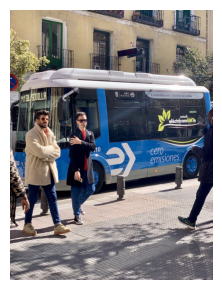

In [4]:
filepath = keras.utils.get_file(origin="https://ultralytics.com/images/bus.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=3,
    show=True,
)

To use the `YOLOV8Detector` architecture with a ResNet50 backbone, you'll need to

- resize your image to a size that is divisible by 64.  This is to ensure
compatibility with the number of downscaling operations done by the convolution layers in the ResNet.

- If the resize operation distorts the input's aspect ratio, the model will perform signficantly poorer.  



use KerasCV makes resizing easy; simply use `pad_to_aspect_ratio=True` to
a `keras_cv.layers.Resizing` layer.

In [5]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)
image_batch = inference_resizing([image])

`keras_cv.visualization.plot_bounding_box_gallery()` supports a `class_mapping`
parameter to highlight what class each box was assigned to.  Let's assemble a
class mapping now.

In [6]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


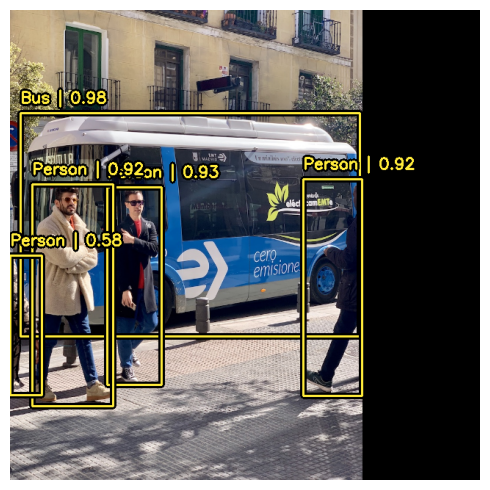

In [7]:
y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
    show=True,

)

## use NonMaxSuppression

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


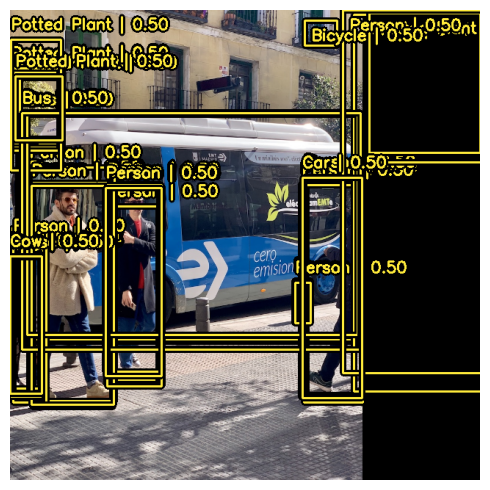

In [8]:
# The following NonMaxSuppression layer
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=1.0,
    confidence_threshold=0.0,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
    show=True,
)


-  we will tune the `iou_threshold` to `0.2`, and the
`confidence_threshold` to `0.7`.

- Raising the `confidence_threshold` will cause the model to only output boxesthat have a higher confidence score.

- `iou_threshold` controls the threshold of
intersection over union (IoU) that two boxes must have in order for one to bepruned out.

[More information on these parameters may be found in the TensorFlow API docs](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


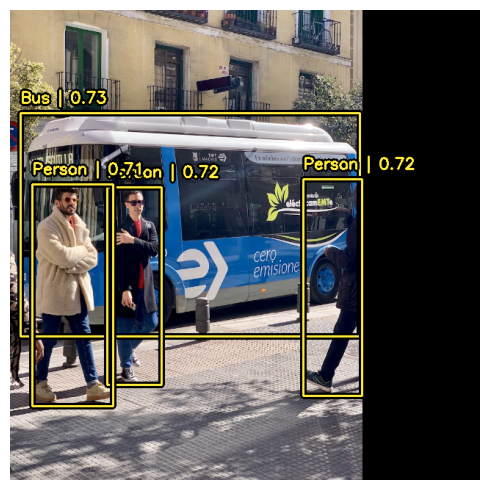

In [9]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.7,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
    show=True,
)



## Train a custom object detection model


In [10]:
BATCH_SIZE = 4

## Data loading


In [11]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}


def load_pascal_voc( dataset, bounding_box_format):

    ds_train ,ds_test  = tfds.load(dataset, split=['train', 'test'], with_info=False, shuffle_files=True ,
                   download_and_prepare_kwargs={'download_config': download_config})

    ds_train = ds_train.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )

    ds_test = ds_test.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )

    return ds_train ,ds_test


download_config = tfds.download.DownloadConfig( manual_dir = '/content/download' , extract_dir ='/content/pascalvoc',
    download_mode="FORCE_REDOWNLOAD" , override_max_simultaneous_downloads =4)


train_ds , eval_ds= load_pascal_voc(
     dataset="voc/2007", bounding_box_format="xywh"
)


train_ds = train_ds.shuffle(BATCH_SIZE * 4)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteAVSXGO/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteAVSXGO/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteAVSXGO/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [12]:
#!rm -rf /root/tensorflow_datasets/voc/2007/4.0.0

batch the data.

- KerasCV object detection tasks it is recommended that
users use ragged batches of inputs.

- as images may be of different sizes in PascalVOC,
- also the fact that there may be different numbers of bounding boxes per image.

To construct a ragged dataset in a `tf.data` pipeline, you can use the
`ragged_batch()` method.

In [13]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

visualize train set:

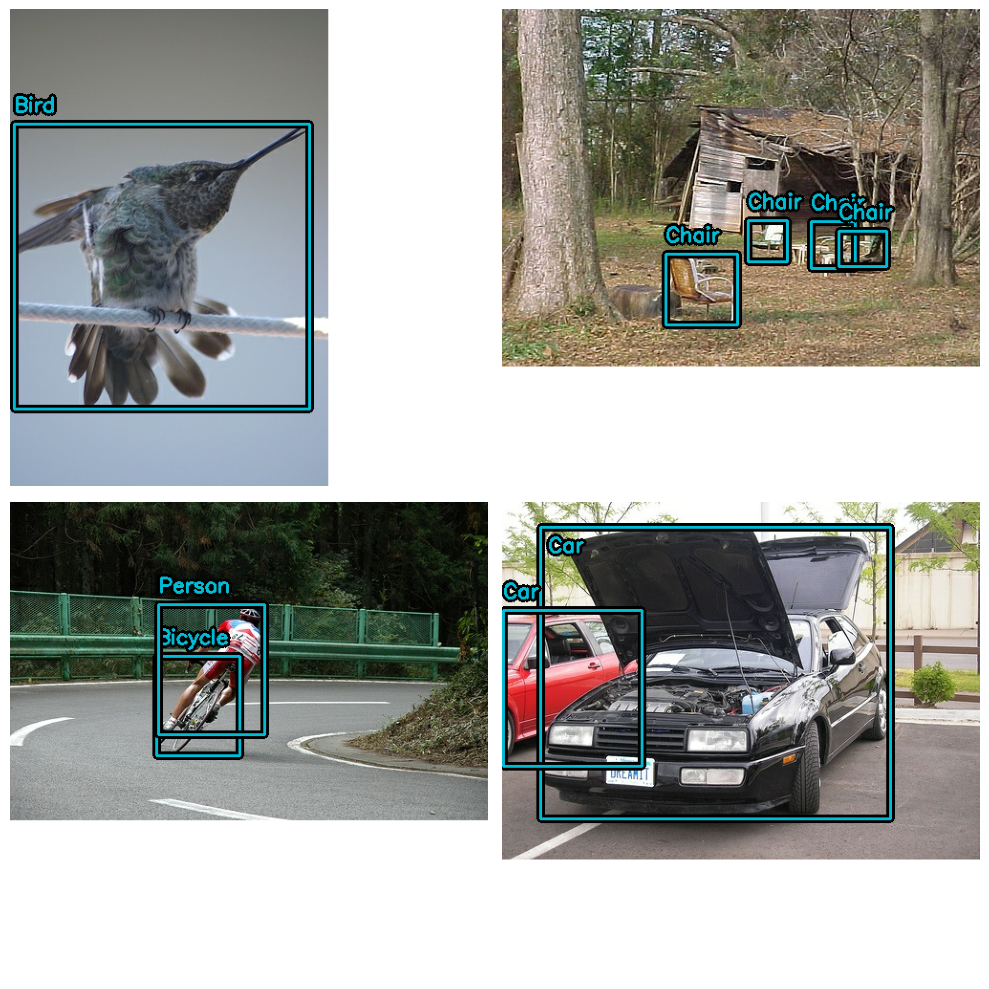

In [14]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

And for the eval set:

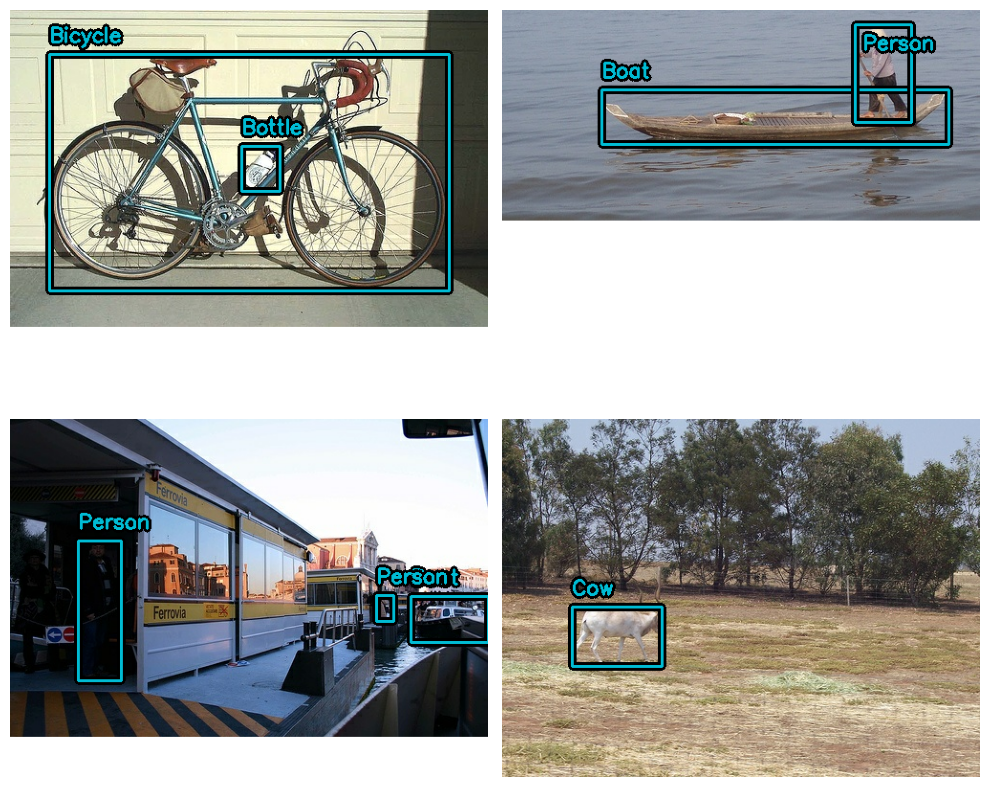

In [15]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,

    # If you are not running your experiment on a local machine, you can also
    # make `visualize_dataset()` dump the plot to a file using `path`:
    # path="eval.png"
)

## Data augmentation

Image augmentation techniques must be aware of the bounding boxes, and must update them accordingly.

KerasCV supports bounding box augmentation

[data augmentation layers](https://keras.io/api/keras_cv/layers/preprocessing/).


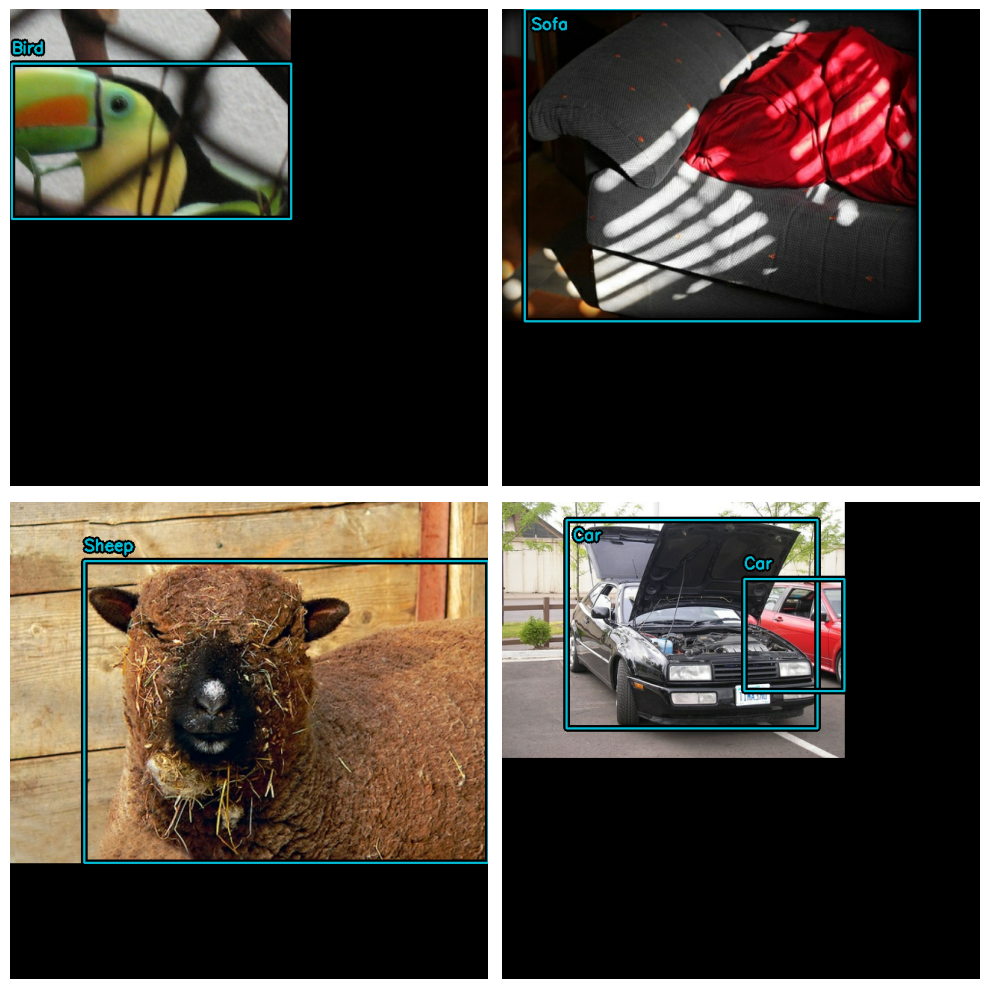

In [16]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    ),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

Resize test set using  `keras_cv.layers.Resizing()`
layer.

In [17]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

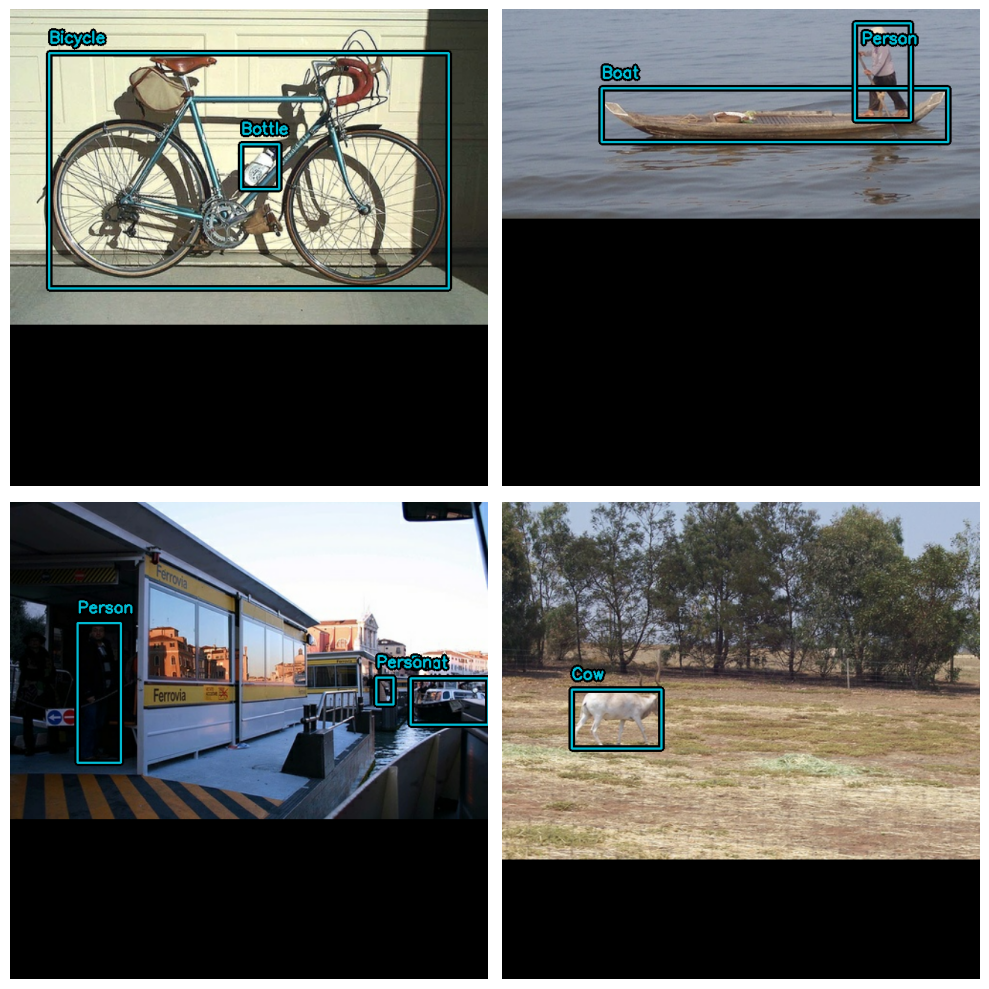

In [18]:
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

Finally, let's unpackage our inputs from the preprocessing dictionary, and
prepare to feed the inputs into our model.

In [19]:

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)

### Optimizer

In this guide, we use a standard SGD optimizer

You will always want to include a `global_clipnorm` when training object
detection models.  

This is to remedy exploding gradient problems that frequently
occur when training object detection models.

In [20]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

To achieve the best results on your dataset, you'll likely want to hand craft a
`PiecewiseConstantDecay` learning rate schedule.
While `PiecewiseConstantDecay` schedules tend to perform better, they don't
translate between problems.

### Loss functions

You may not be familiar with the `"ciou"` loss.  While not common in other
models, this loss is sometimes used in the object detection world.


In [21]:
pretrained_model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
)

### Metric evaluation

The most popular object detection metrics are COCO metrics,
which were published alongside the MSCOCO dataset.

 KerasCV provides an
easy-to-use suite of COCO metrics under the `keras_cv.callbacks.PyCOCOCallback`
symbol.

In [22]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds.take(20 ), bounding_box_format="xywh"
)




## Model creation

construct a `YOLOV8Detector` with any of the KerasCV
backbones.

In [23]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    num_classes=20,
)

100%|██████████| 777/777 [00:00<00:00, 724kB/s]
100%|██████████| 90.3M/90.3M [00:01<00:00, 89.6MB/s]


That is all it takes to construct a KerasCV YOLOv8. The YOLOv8 accepts
tuples of dense image Tensors and bounding box dictionaries to `fit()` and
`train_on_batch()`



## Training our model




In [24]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

If you want to fully train the model, remove `.take(20)` from all dataset
references (below and in the initialization of the metrics callback).

In [25]:
model.fit(
    train_ds.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=1,
    callbacks=[coco_metrics_callback],
)

20/20 ━━━━━━━━━━━━━━━━━━━━ 551s 27s/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.45s).
Accumulating evaluation results...
DONE (t=0.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 

## Inference and plotting results

KerasCV makes object detection inference simple.  `model.predict(images)`
returns a tensor of bounding boxes.  By default, `YOLOV8Detector.predict()`

- and it will perform a non max suppression operation for you.

In this section, we will use a `keras_cv` provided preset:

In [26]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

Next, for convenience we construct a dataset with larger batches:

In [27]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

Let's create a simple function to plot our inferences:

In [28]:

def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


You may need to configure your NonMaxSuppression operation to achieve
visually appealing results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step


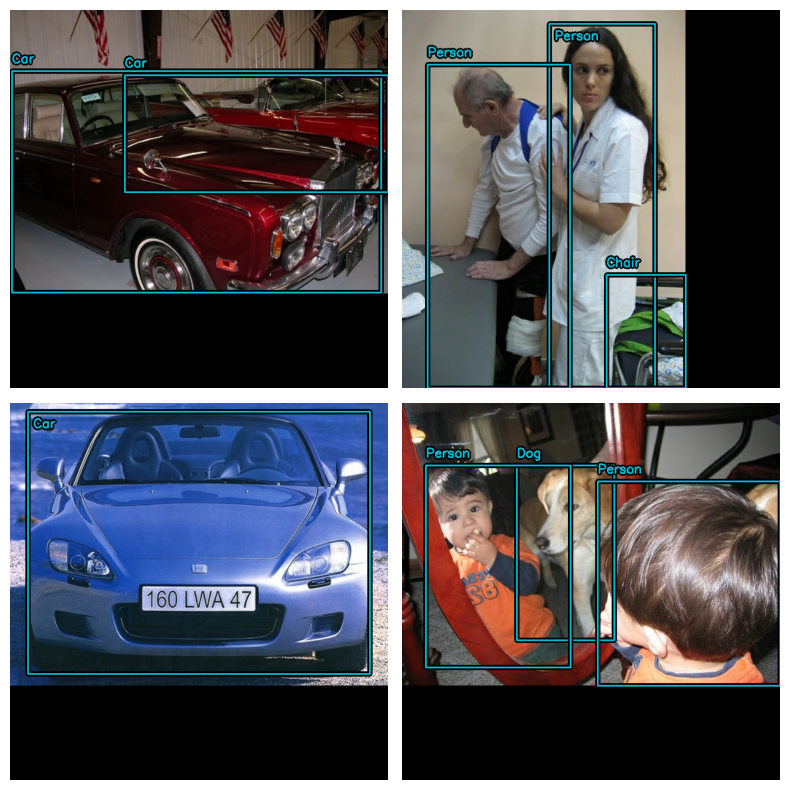

In [29]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")